# Exercise 1: HOG (Histogram of Oriented Gradients) Object Detection

## Task
HOG is a feature descriptor widely used for object detection, particularly for human detection. In this exercise, you will:
* Load an image containing a person or an object.
* Convert the image to grayscale.
* Apply the HOG descriptor to extract features.
* Visualize the gradient orientations on the image.
* Implement a simple object detector using HOG features.

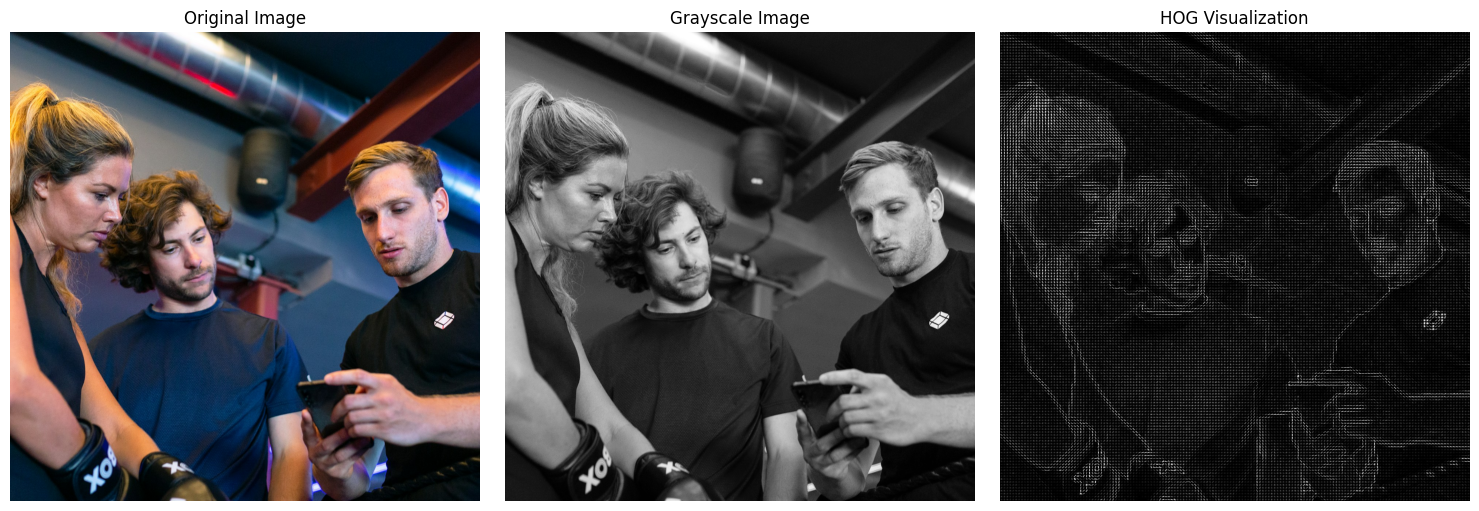

In [10]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
  # Load the image
  image = cv2.imread(image_path)

  # Get the dimensions of the image
  height, width = image.shape[:2]

  # Calculate the size of the square crop
  crop_size = min(height, width)

  # Calculate the starting point for cropping
  start_x = (width - crop_size) // 2
  start_y = (height - crop_size) // 2

  # Crop the image to a square
  cropped_image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]

  # Convert the image to grayscale
  gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

  return cropped_image, gray_image

def apply_hog(gray_image):
  # Apply HOG descriptor
  features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True)

  # Rescale the HOG image for better visualization
  hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

  return features, hog_image_rescaled

def visualize_results(original_image, gray_image, hog_image):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

  ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
  ax1.set_title('Original Image')
  ax1.axis('off')

  ax2.imshow(gray_image, cmap='gray')
  ax2.set_title('Grayscale Image')
  ax2.axis('off')

  ax3.imshow(hog_image, cmap='gray')
  ax3.set_title('HOG Visualization')
  ax3.axis('off')

  plt.tight_layout()
  plt.show()

def main():
  image_path = 'people.jpg'

  # Load and preprocess the image
  original_image, gray_image = load_and_preprocess_image(image_path)

  # Apply HOG descriptor
  hog_features, hog_image = apply_hog(gray_image)

  # Visualize the results
  visualize_results(original_image, gray_image, hog_image)

if __name__ == "__main__":
  main()

The code above first reads an image from a particular path, then proceeds with pre-processing. It crops the image to a square shape by finding its minimum dimension, along with further conversion into a grayscale intensity image for further analysis.

The HOG descriptor is then applied on the grayscale image. It extracts features and produces a HOG visualization. The visualization makes it easier to identify gradient orientations in an image that may contribute to the eventual recognition of a pattern or shape.

At the last stage, all the results are shown in a single figure containing three subplots in such an order of original image, grayscale image, and HOG visualization. With this layout, it is possible to be able to look at how each of the various steps in the processing of an image alters it.

## Key Points
* HOG focuses on the structure of objects through gradients.
* Useful for detecting humans and general object recognition

# Exercise 2: YOLO (You Only Look Once) Object Detection

## Task
YOLO is a deep learning-based object detection method. In this exercise, you will:
* Load a pre-trained YOLO model using TensorFlow.
* Feed an image to the YOLO model for object detection.
* Visualize the bounding boxes and class labels on the detected objects in the image.
* Test the model on multiple images to observe its performance.

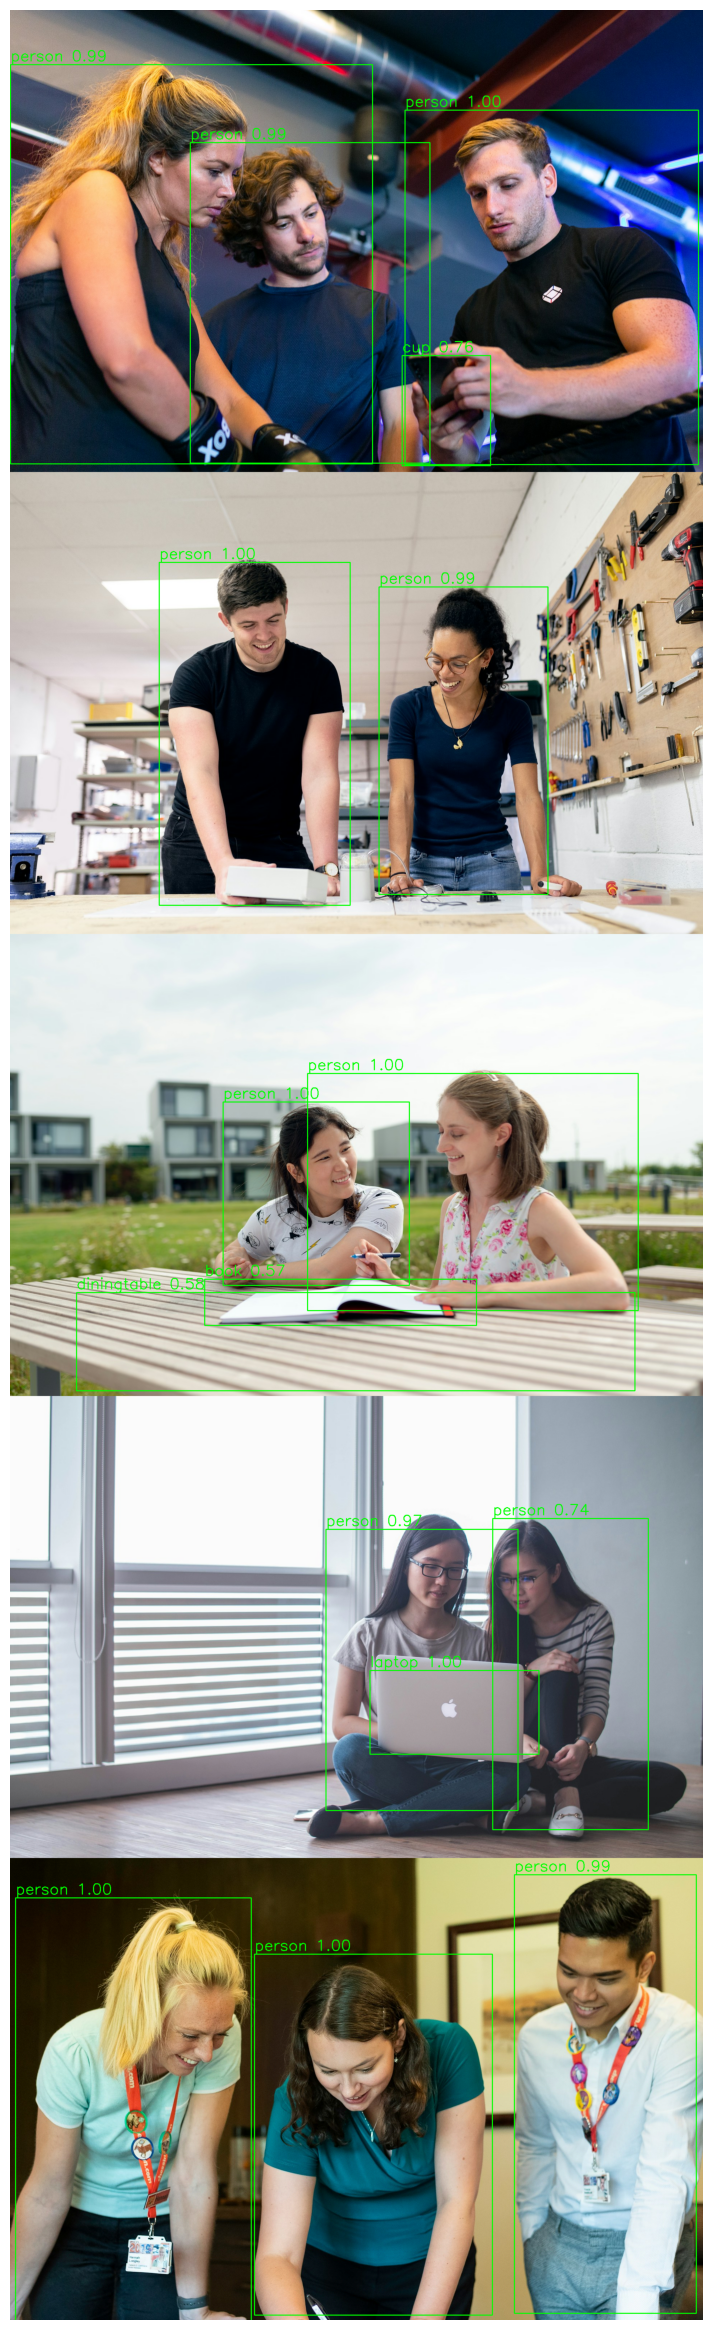

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load YOLO model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load the class names (COCO dataset)
with open("coco.names", "r") as f:
  classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# List of image file names
image_files = ["people.jpg", "people-2.jpg", "people-3.jpg", "people-4.jpg", "people-5.jpg"]

processed_images = []
target_aspect_ratio = (3, 2)  # 3:2 aspect ratio

def crop_to_aspect_ratio(image, aspect_ratio):
  """Crops the image to the desired aspect ratio by performing a center crop."""
  h, w, _ = image.shape
  target_w = w
  target_h = int(w / aspect_ratio[0] * aspect_ratio[1])

  # If the height is larger than the target height, we crop it vertically
  if target_h > h:
    target_h = h
    target_w = int(h * aspect_ratio[0] / aspect_ratio[1])

  # Compute cropping margins for center cropping
  x_margin = (w - target_w) // 2
  y_margin = (h - target_h) // 2

  cropped_image = image[y_margin:y_margin + target_h, x_margin:x_margin + target_w]
  return cropped_image

for image_file in image_files:
  # Load the image
  image = cv2.imread(image_file)

  # Crop the image to a 3:2 aspect ratio
  cropped_image = crop_to_aspect_ratio(image, target_aspect_ratio)
  height, width, channels = cropped_image.shape

  # Prepare the image for YOLO
  blob = cv2.dnn.blobFromImage(cropped_image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(output_layers)

  # Process YOLO outputs
  class_ids = []
  confidences = []
  boxes = []

  for out in outs:
    for detection in out:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      if confidence > 0.5:
        # Object detected
        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        w = int(detection[2] * width)
        h = int(detection[3] * height)
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)

        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(class_id)

  # Apply non-max suppression to remove overlapping boxes
  indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

  # Draw bounding boxes and labels with larger green font
  for i in indices:
    box = boxes[i]
    x, y, w, h = box
    label = str(classes[class_ids[i]])
    confidence = confidences[i]

    # Draw bounding box
    cv2.rectangle(cropped_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Increase font size and change color to green
    font_scale = 1.4  # Increase font size
    font_color = (0, 255, 0)  # Green color
    thickness = 2  # Thickness of the font
    cv2.putText(cropped_image, f"{label} {confidence:.2f}", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_color, thickness)

  # Convert BGR image to RGB for displaying using matplotlib
  image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

  # Append processed image to the list
  processed_images.append(image_rgb)

# Concatenate images vertically in a 5x1 grid
result_image = np.vstack(processed_images)

# Show the final image grid
plt.figure(figsize=(10, 30))
plt.imshow(result_image)
plt.axis('off')
plt.show()

The code written above uses YOLO with OpenCV to execute an object detection pipeline. This code loads the weights and configuration of the YOLO model along with class names from the COCO dataset. The code then goes through a sequence of images cropped to a 3:2 aspect ratio. It's the result of a predefined function that performs a center crop. With each of the cropped images, a blob is created for sizing down to 416x416 pixels for proper input into the YOLO network.

Next, the code runs the YOLO model to detect objects on each image, and the code selects which object detected to include in its output - filtering based on confidence score and implementing the non-max suppression to remove overlapping bounding boxes. It overlays the bounding boxes and labels on the images while adjusting the font size and color to make it more visible. After processing, images are transformed from BGR format to RGB as required for display using Matplotlib library.

In the output of object detection, there exists a number of objects with their related confidence scores. For example in the first image, it is clearly identified several persons with high confidence scores while it incorrectly has labelled the cup as a phone. Similar results are delivered in other images also wherein it has correctly classified persons in maximum instances though it does misclassify such as classifying a dining object and a book with lower confidence scores. Overall, the YOLO model gives great performance in the detection of people across all images while producing some occasional errors in classification.

## Key Points
* YOLO is fast and suitable for real-time object detection.
* It performs detection in a single pass, making it efficient for complex scenes.

# Exercise 3: SSD (Single Shot MultiBox Detector) with TensorFlow

## Task
SSD is a real-time object detection method. For this exercise:
* Load an image of your choice.
* Utilize the TensorFlow Object Detection API to apply the SSD model.
* Detect objects within the image and draw bounding boxes around them.
* Compare the results with those obtained from the YOLO model.

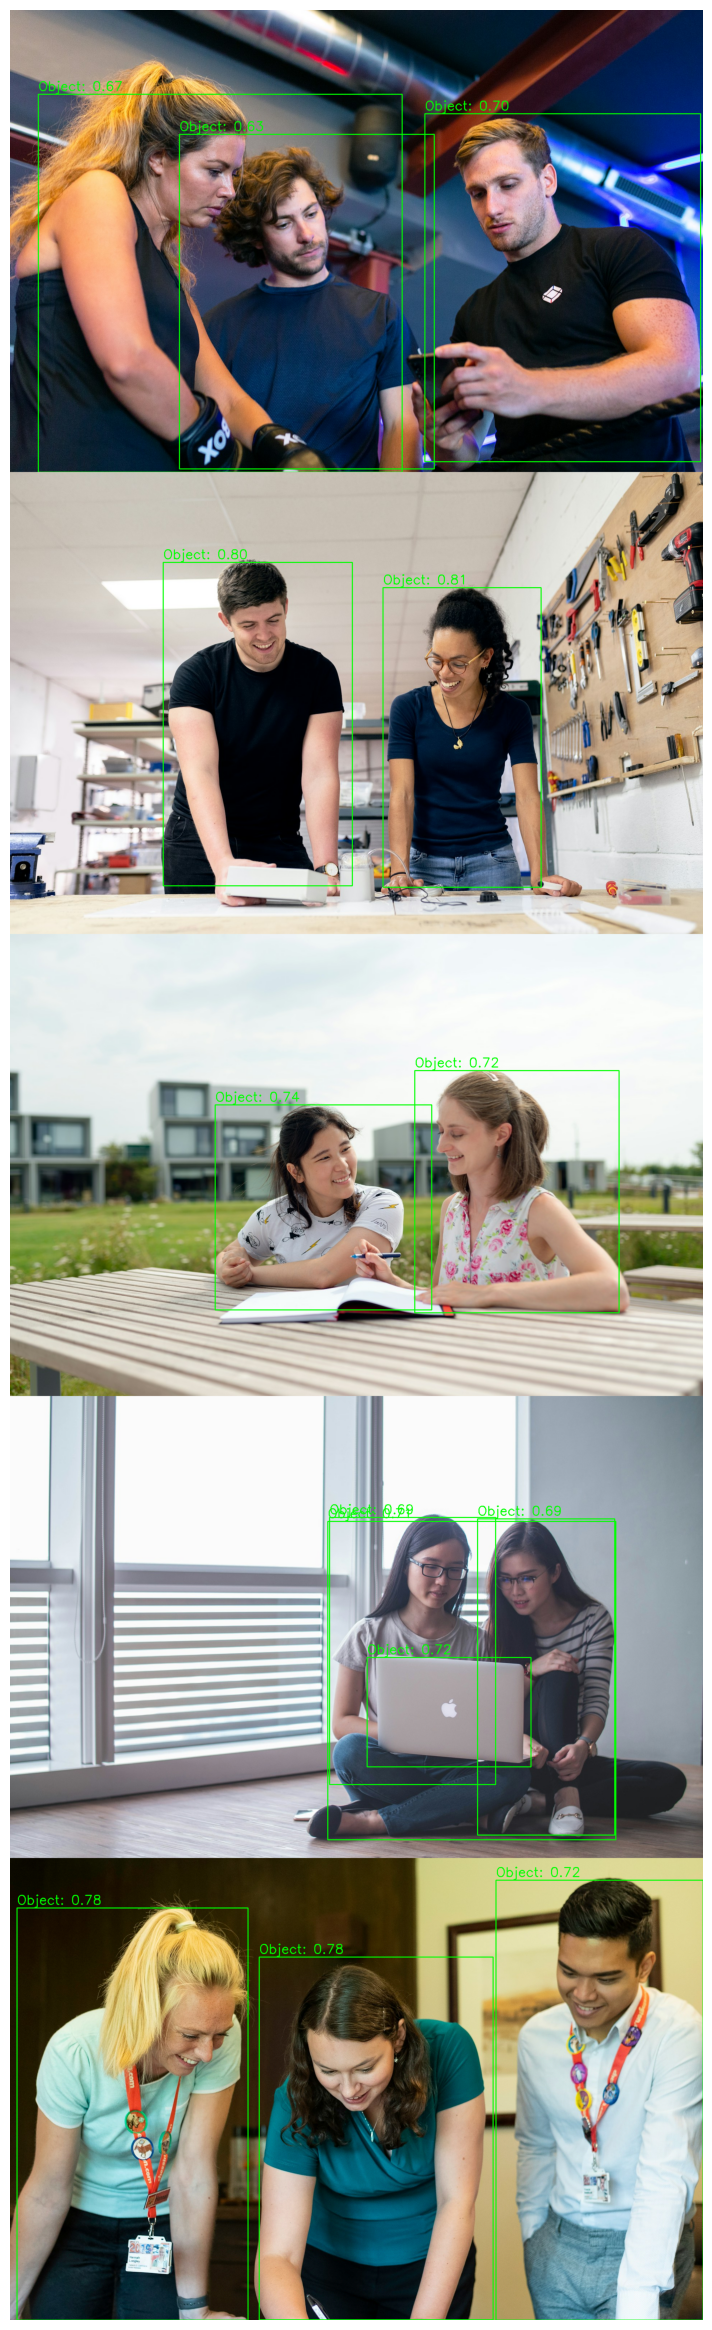

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SSD MobileNet V2 model from TensorFlow Hub
model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

# List of image file names
image_files = ["people.jpg", "people-2.jpg", "people-3.jpg", "people-4.jpg", "people-5.jpg"]

processed_images = []
target_aspect_ratio = (3, 2)  # 3:2 aspect ratio for cropping

def crop_to_aspect_ratio(image, aspect_ratio):
  """Crops the image to the desired aspect ratio by performing a center crop."""
  h, w, _ = image.shape
  target_w = w
  target_h = int(w / aspect_ratio[0] * aspect_ratio[1])

  if target_h > h:
    target_h = h
    target_w = int(h * aspect_ratio[0] / aspect_ratio[1])

  x_margin = (w - target_w) // 2
  y_margin = (h - target_h) // 2

  return image[y_margin:y_margin + target_h, x_margin:x_margin + target_w]

for image_file in image_files:
  # Load and crop the image to the target aspect ratio
  image_np = cv2.imread(image_file)
  image_np_cropped = crop_to_aspect_ratio(image_np, target_aspect_ratio)

  # Convert the image to a tensor
  input_tensor = tf.convert_to_tensor(image_np_cropped)
  input_tensor = input_tensor[tf.newaxis, ...]

  # Run the model to detect objects
  results = model(input_tensor)

  # Extract the detection data
  detection_boxes = results['detection_boxes'][0].numpy()
  detection_scores = results['detection_scores'][0].numpy()
  detection_classes = results['detection_classes'][0].numpy().astype(np.int64)

  # Set confidence threshold
  confidence_threshold = 0.5

  # Draw bounding boxes for detected objects
  for i in range(detection_boxes.shape[0]):
    confidence = detection_scores[i]
    if confidence > confidence_threshold:
      # Get bounding box coordinates
      ymin, xmin, ymax, xmax = detection_boxes[i]
      (left, right, top, bottom) = (xmin * image_np_cropped.shape[1], xmax * image_np_cropped.shape[1],
                                    ymin * image_np_cropped.shape[0], ymax * image_np_cropped.shape[0])
      # Draw bounding box
      cv2.rectangle(image_np_cropped, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)
      # Get class label and confidence score
      label = f"Object: {confidence:.2f}"
      # Draw label with green color and larger font
      cv2.putText(image_np_cropped, label, (int(left), int(top) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

  # Convert BGR image to RGB for matplotlib display
  image_rgb = cv2.cvtColor(image_np_cropped, cv2.COLOR_BGR2RGB)
  processed_images.append(image_rgb)

# Concatenate all images vertically in a 5x1 grid
result_image = np.vstack(processed_images)

# Display the final result in a grid
plt.figure(figsize=(10, 30))
plt.imshow(result_image)
plt.axis('off')
plt.show()

The following code configures an object detection pipeline using the SSD MobileNet V2 model from TensorFlow Hub. The process begins with importing the pre-trained model and then defines a list of the image files to be analyzed. Each image reads and crops, utilizing a function that centers it into a 3:2 aspect ratio so that all the inputs are uniform.

After the images are cropped, they undergo a conversion to tensors and are then used to input into the TensorFlow model. It iterates over the tensor, detecting objects and returning detection boxes, confidence scores, and class identifiers for every detected object. A threshold of 0.5 is set for confidence scores to eliminate detections where the detection confidence is less than 0.5.

Bounding boxes are drawn around the detected areas in the images along with labels mentioning the confidence score for all detected objects that are above a given confidence threshold. The processed images are then converted from BGR to RGB format and prepared for visualization using Matplotlib.

Different confidence scores are shown in each of the images. For instance, in the first image several objects are detected with confidence scores between 0.63 and 0.70. The same results can be obtained for other images. The second shows even higher scores of 0.80 and 0.81. Scores in the third to fifth images also explain successful detections since most confidence scores remain above 0.70. It proves that SSD MobileNet V2 is really good at detecting objects in a given set of images but shows all the labels generically as "Object" without actually showing any particular class of object.

## Key Points
* SSD is efficient in terms of speed and accuracy.
* Ideal for applications requiring both speed and moderate precision.

# Exercise 4: Traditional vs. Deep Learning Object Detection Comparison

## Task
Compare traditional object detection (e.g., HOG-SVM) with deep learning-based methods (YOLO, SSD):
* Implement HOG-SVM and either YOLO or SSD for the same dataset.
* Compare their performances in terms of accuracy and speed.
* Document the advantages and disadvantages of each method.

In [17]:
import cv2
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from skimage.feature import hog
import time
import torch
from ultralytics import YOLO
import warnings
import logging

# Suppress warnings and info messages
warnings.filterwarnings("ignore")
logging.getLogger("ultralytics").setLevel(logging.ERROR)

# HOG-SVM Implementation
def hog_svm_detect(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  resized = cv2.resize(gray, (64, 128))
  features = hog(resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
  prediction = svm_model.predict([features])[0]
  return prediction

# YOLO Implementation
def yolo_detect(image):
  with torch.no_grad():
    results = yolo_model(image, verbose=False)
  for r in results:
    if 0 in r.boxes.cls:
      return 1
  return 0

# Load and train HOG-SVM model
def train_hog_svm(training_images, training_labels):
  features = []
  for img_path in training_images:
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 128))
    feature = hog(resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    features.append(feature)
  svm_model = svm.SVC(kernel='linear')
  svm_model.fit(features, training_labels)
  return svm_model

# Load pre-trained models
training_images = ["people.jpg", "people-2.jpg", "people-3.jpg", "no-people.jpg", "no-people-2.jpg"]
training_labels = [1, 1, 1, 0, 0]

svm_model = train_hog_svm(training_images, training_labels)
yolo_model = YOLO('yolov5s.pt')

# Test on a dataset
def evaluate_models(test_images, ground_truth):
  hog_svm_results = []
  yolo_results = []
  hog_svm_time = 0
  yolo_time = 0

  for image_path, gt in zip(test_images, ground_truth):
    image = cv2.imread(image_path)

    # HOG-SVM
    start_time = time.time()
    hog_svm_pred = hog_svm_detect(image)
    hog_svm_time += time.time() - start_time
    hog_svm_results.append(hog_svm_pred)

    # YOLO
    start_time = time.time()
    yolo_pred = yolo_detect(image)
    yolo_time += time.time() - start_time
    yolo_results.append(yolo_pred)

  hog_svm_accuracy = accuracy_score(ground_truth, hog_svm_results)
  yolo_accuracy = accuracy_score(ground_truth, yolo_results)

  return hog_svm_accuracy, yolo_accuracy, hog_svm_time, yolo_time

# Main execution
test_images = ["people-4.jpg", "people-5.jpg", "no-people-3.jpg"]
ground_truth = [1, 1, 0]

hog_svm_acc, yolo_acc, hog_svm_time, yolo_time = evaluate_models(test_images, ground_truth)

print(f"HOG-SVM Accuracy: {hog_svm_acc:.4f}")
print(f"YOLO Accuracy: {yolo_acc:.4f}")
print(f"HOG-SVM Total Time: {hog_svm_time:.4f} seconds")
print(f"YOLO Total Time: {yolo_time:.4f} seconds")

HOG-SVM Accuracy: 0.6667
YOLO Accuracy: 1.0000
HOG-SVM Total Time: 0.0206 seconds
YOLO Total Time: 1.1926 seconds


The following code above compares two object detection techniques which are HOG-SVM and YOLO. The technique HOG-SVM first extracts features from the input images. The code converts the images to grayscale, resizes them, and utilizes the HOG technique, which produces a feature vector. It now uses that vector as input to the SVM model for the purpose of prediction to classify whether the target object is presented in the image or not.

On the other hand, the YOLO approach depends on a pre-trained YOLO model to classify objects of interest right from the image. It checks whether the detected objects fall into a class of interest thus making it possible to do real-time detection in an efficient manner. The script consists of a training phase for the HOG-SVM model, which takes on a labeled dataset of images. This dataset contains the presence or absence of the object of interest labeled to be a person, among other things.

During the evaluation phase, the two models are tested on the same dataset of images. The script write down the result of their predictions and compute metrics on the accuracy of each method. Additionally, the total time taken to process by each approach allow for a direct comparison of the two models. Thus, the output shows the accuracy and efficiency of the HOG-SVM and YOLO methods, which could give a better understanding of which performs better in object detection tasks.

* `HOG-SVM Accuracy: 0.6667`
* `YOLO Accuracy: 1.0000`
* `HOG-SVM Total Time: 0.0206 seconds`
* `YOLO Total Time: 1.1926 seconds`

The results of such experiments also outline a pretty relevant difference between the two object detection methods under investigation: HOG-SVM and YOLO. For example, the accuracy achieved by the HOG-SVM model in the case at hand was 0.6667, meaning that it correctly detected the occurrence of objects in about two thirds of its results. In contrast, the model of the YOLO resulted in the perfect accuracy of 1.0000 and correctly detected all of the target objects used in the test dataset in actuality. This drastic difference clearly shows that YOLO is far more accurate in identifying the objects of interest in these test images.

Although YOLO is more accurate, it consumes more processing time. The proof lies in its total processing time on each image, with a difference of 1.1926 seconds from HOG-SVM's mere 0.0206 seconds. This means, even though YOLO detection is more accurate, it is slower and not suitable for real-time applications. While, HOG-SVM approach may not be so accurate but is much faster. So, in such scenarios, where execution speed is the first priority, but where a little distortion in accuracy can be tolerated, this approach applies.

The advantages of HOG-SVM is that it is faster than other methods, and hence suitable for real-time applications; simpler than other methods; however, may not be as precise as deep learning-based methods like YOLO, especially when objects are partially occluded from the camera and in complex scenes. Does not generalize well to different datasets or if the appearance changes.

On the other hand, YOLO is more accurate in object detection hence appropriate when it comes to applications where reliable and accurate detections are necessary. It can apply various real-time applications despite taking more processing time compared to HOG-SVM. The YOLO is computationally intensive, therefore is more likely to take a longer time to process, which might be its limitation in places where the output needs to come immediately. Complexity is another weakness, since models of YOLO are complex to configure, and thus the capability needed to compute these is more comprehensive, thereby less accessible for minor applications.

In conclusion, the choice between HOG-SVM and YOLO depends solely on the particular application's requirements in terms of accuracy tolerance versus speed of processing. For demanding applications where accuracy matters the most, it would be better off choosing YOLO, while HOG-SVM is preferred in applications that are rapid detection-oriented over accuracy.

## Key Points
* Traditional methods may perform better in resource-constrained environments.
* Deep learning methods are generally more accurate but require more computational power.

In [19]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Exercise 4 - Objection Detection and Recognition.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Exercise 4 - Objection Detection and Recognition.ipynb to pdf
[NbConvertApp] Support files will be in Exercise 4 - Objection Detection and Recognition_files/
[NbConvertApp] Making directory ./Exercise 4 - Objection Detection and Recognition_files
[NbConvertApp] Writing 66745 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 934802 bytes to /content/drive/MyDrive/Colab Notebooks/Exercise 4 - Objection Detection and Recognition.pdf
